In [12]:
from src.config import DEFAULT_DATA_FOLDER
from src.models.lstm.utils import determine_labels
from src.data.utils import save_as_excel

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt

In [2]:
# load datasets
# Load the dataset
DATASET_PATH = f"{DEFAULT_DATA_FOLDER}/output/combined_posts_results.xlsx"
dataset = pd.read_excel(DATASET_PATH)

# Load pre-trained Word2Vec embeddings
word2vec_path = f'{DEFAULT_DATA_FOLDER}/word-embedding/SO_vectors_200.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path,binary=True)

In [3]:
# Prepare the dataset
dataset['category'] = dataset.apply(determine_labels, axis=1)
dataset['clean_text'] = dataset['clean_text'].fillna('').astype(str)

In [4]:
label_encoder = LabelEncoder()
dataset['category'] = label_encoder.fit_transform(dataset['category'])
num_classes = len(label_encoder.classes_)

In [5]:
# Tokenize and pad sequences
max_num_words = dataset['clean_text'].str.len().max()
max_sequence_length = 250
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(dataset['clean_text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dataset['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
labels_categorical = to_categorical(dataset['category'], num_classes=num_classes)

In [6]:
# hyper-parameters: these are calculated using optimize parameters notebook
embedding_dim = 200
lstm_units = 100
dropout_rate = 0.2
batch_size = 16
epochs = 20

In [7]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1

In [8]:
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# To store the results
results = []

for train_index, test_index in kf.split(padded_sequences, dataset['category']):
    print(f'Training on fold {fold_no} with params: embedding_dim={embedding_dim}, lstm_units={lstm_units}, dropout_rate={dropout_rate}, batch_size={batch_size}')

    X_train, X_test = padded_sequences[train_index], padded_sequences[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    # Build the LSTM model with pre-trained embeddings
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                        callbacks=[early_stopping], verbose=2)

    # Evaluate the model
    y_pred = model.predict(X_test, verbose=2)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = np.mean(y_pred_classes == y_true)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f'Test Accuracy for fold {fold_no}: {accuracy}')
    print(f'Test Precision for fold {fold_no}: {precision}')
    print(f'Test Recall for fold {fold_no}: {recall}')
    print(f'Test F1 Score for fold {fold_no}: {f1}')

    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    # Store the results
    fold_results = pd.DataFrame({
        'fold': fold_no,
        'true': y_true,
        'predicted': y_pred_classes
    })
    results.append(fold_results)

    fold_no += 1
    
    save_as_excel(fold_results, f"{DEFAULT_DATA_FOLDER}/validation_results/fold{fold_no}.xlsx")
    
print("Fold accuracies: ", fold_accuracies)
print("Fold precisions: ", fold_precisions)
print("Fold recalls: ", fold_recalls)
print("Fold f1 scores: ", fold_f1_scores)

Training on fold 1 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=16
Epoch 1/20
121/121 - 21s - 171ms/step - accuracy: 0.6341 - loss: 0.9632 - val_accuracy: 0.9628 - val_loss: 0.2101
Epoch 2/20
121/121 - 24s - 200ms/step - accuracy: 0.7084 - loss: 0.7500 - val_accuracy: 0.9116 - val_loss: 0.2747
Epoch 3/20
121/121 - 29s - 241ms/step - accuracy: 0.7447 - loss: 0.6532 - val_accuracy: 0.9070 - val_loss: 0.2502
Epoch 4/20
121/121 - 29s - 237ms/step - accuracy: 0.7815 - loss: 0.5609 - val_accuracy: 0.9070 - val_loss: 0.1970
Epoch 5/20
121/121 - 23s - 187ms/step - accuracy: 0.8199 - loss: 0.4873 - val_accuracy: 0.9395 - val_loss: 0.1455
Epoch 6/20
121/121 - 26s - 215ms/step - accuracy: 0.8350 - loss: 0.4594 - val_accuracy: 0.8930 - val_loss: 0.2506
Epoch 7/20
121/121 - 27s - 226ms/step - accuracy: 0.8625 - loss: 0.3929 - val_accuracy: 0.9163 - val_loss: 0.2161
Epoch 8/20
121/121 - 27s - 222ms/step - accuracy: 0.8739 - loss: 0.3554 - val_accuracy: 0.9535 - val_lo

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 22s - 186ms/step - accuracy: 0.6367 - loss: 0.9526 - val_accuracy: 0.9767 - val_loss: 0.1850
Epoch 2/20
121/121 - 22s - 183ms/step - accuracy: 0.7182 - loss: 0.7213 - val_accuracy: 0.9814 - val_loss: 0.1738
Epoch 3/20
121/121 - 23s - 193ms/step - accuracy: 0.7483 - loss: 0.6476 - val_accuracy: 0.9628 - val_loss: 0.1502
Epoch 4/20
121/121 - 22s - 178ms/step - accuracy: 0.7800 - loss: 0.5676 - val_accuracy: 0.9674 - val_loss: 0.1417
Epoch 5/20
121/121 - 20s - 164ms/step - accuracy: 0.8044 - loss: 0.5108 - val_accuracy: 0.8558 - val_loss: 0.3644
Epoch 6/20
121/121 - 20s - 166ms/step - accuracy: 0.8251 - loss: 0.4600 - val_accuracy: 0.9535 - val_loss: 0.1334
Epoch 7/20
121/121 - 21s - 170ms/step - accuracy: 0.8635 - loss: 0.3896 - val_accuracy: 0.9302 - val_loss: 0.2026
Epoch 8/20
121/121 - 21s - 176ms/step - accuracy: 0.8718 - loss: 0.3619 - val_accuracy: 0.9535 - val_loss: 0.1333
Epoch 9/20
121/121 - 23s - 192ms/step - accuracy: 0.8936 - loss: 0.3139 - val_accuracy: 0.9209 - va

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 16s - 136ms/step - accuracy: 0.6352 - loss: 0.9422 - val_accuracy: 0.9070 - val_loss: 0.3001
Epoch 2/20
121/121 - 18s - 148ms/step - accuracy: 0.7042 - loss: 0.7377 - val_accuracy: 0.9209 - val_loss: 0.2378
Epoch 3/20
121/121 - 24s - 196ms/step - accuracy: 0.7545 - loss: 0.6355 - val_accuracy: 0.9302 - val_loss: 0.1514
Epoch 4/20
121/121 - 22s - 180ms/step - accuracy: 0.7701 - loss: 0.5870 - val_accuracy: 0.9674 - val_loss: 0.1461
Epoch 5/20
121/121 - 21s - 174ms/step - accuracy: 0.8106 - loss: 0.5140 - val_accuracy: 0.9209 - val_loss: 0.1862
Epoch 6/20
121/121 - 22s - 182ms/step - accuracy: 0.8443 - loss: 0.4619 - val_accuracy: 0.9116 - val_loss: 0.2258
Epoch 7/20
121/121 - 19s - 160ms/step - accuracy: 0.8485 - loss: 0.4126 - val_accuracy: 0.9302 - val_loss: 0.1708
8/8 - 1s - 82ms/step
Test Accuracy for fold 6: 0.7352941176470589
Test Precision for fold 6: 0.6820352264327892
Test Recall for fold 6: 0.7352941176470589
Test F1 Score for fold 6: 0.702905188771838
Training on fo

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 17s - 142ms/step - accuracy: 0.6175 - loss: 0.9921 - val_accuracy: 0.9628 - val_loss: 0.2803
Epoch 2/20
121/121 - 18s - 149ms/step - accuracy: 0.7037 - loss: 0.7472 - val_accuracy: 0.9674 - val_loss: 0.1408
Epoch 3/20
121/121 - 19s - 159ms/step - accuracy: 0.7509 - loss: 0.6354 - val_accuracy: 0.9860 - val_loss: 0.0910
Epoch 4/20
121/121 - 21s - 173ms/step - accuracy: 0.7857 - loss: 0.5689 - val_accuracy: 0.9628 - val_loss: 0.1550
Epoch 5/20
121/121 - 20s - 165ms/step - accuracy: 0.7961 - loss: 0.5349 - val_accuracy: 0.9535 - val_loss: 0.1511
Epoch 6/20
121/121 - 20s - 168ms/step - accuracy: 0.8287 - loss: 0.4753 - val_accuracy: 0.9581 - val_loss: 0.1329
8/8 - 1s - 88ms/step
Test Accuracy for fold 8: 0.7436974789915967
Test Precision for fold 8: 0.6903341981954072
Test Recall for fold 8: 0.7436974789915967
Test F1 Score for fold 8: 0.7115530890246787
Training on fold 9 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=16
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 22s - 181ms/step - accuracy: 0.6393 - loss: 0.9620 - val_accuracy: 0.9488 - val_loss: 0.1995
Epoch 2/20
121/121 - 19s - 154ms/step - accuracy: 0.7172 - loss: 0.7122 - val_accuracy: 0.9581 - val_loss: 0.1393
Epoch 3/20
121/121 - 23s - 189ms/step - accuracy: 0.7488 - loss: 0.6269 - val_accuracy: 0.9721 - val_loss: 0.1010
Epoch 4/20
121/121 - 21s - 176ms/step - accuracy: 0.7898 - loss: 0.5474 - val_accuracy: 0.9395 - val_loss: 0.1592
Epoch 5/20
121/121 - 23s - 194ms/step - accuracy: 0.8220 - loss: 0.4977 - val_accuracy: 0.9535 - val_loss: 0.1771
Epoch 6/20
121/121 - 19s - 159ms/step - accuracy: 0.8303 - loss: 0.4510 - val_accuracy: 0.9581 - val_loss: 0.1298
8/8 - 1s - 82ms/step
Test Accuracy for fold 9: 0.7310924369747899
Test Precision for fold 9: 0.6921008403361346
Test Recall for fold 9: 0.7310924369747899
Test F1 Score for fold 9: 0.7000608095988577
Training on fold 10 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=16
Epoch 1/20
121/121 - 17s - 

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Calculate average metrics for current hyperparameters
average_accuracy = np.mean(fold_accuracies)
average_precision = np.mean(fold_precisions)
average_recall = np.mean(fold_recalls)
average_f1_score = np.mean(fold_f1_scores)

print(f'Average Test Accuracy for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_accuracy}')
print(f'Average Test Precision for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_precision}')
print(f'Average Test Recall for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_recall}')
print(f'Average Test F1 Score for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_f1_score}')

Average Test Accuracy for config 200, 100, 0.2, 16: 0.7399159663865547
Average Test Precision for config 200, 100, 0.2, 16: 0.6994369921584933
Average Test Recall for config 200, 100, 0.2, 16: 0.7399159663865547
Average Test F1 Score for config 200, 100, 0.2, 16: 0.7121953907526296


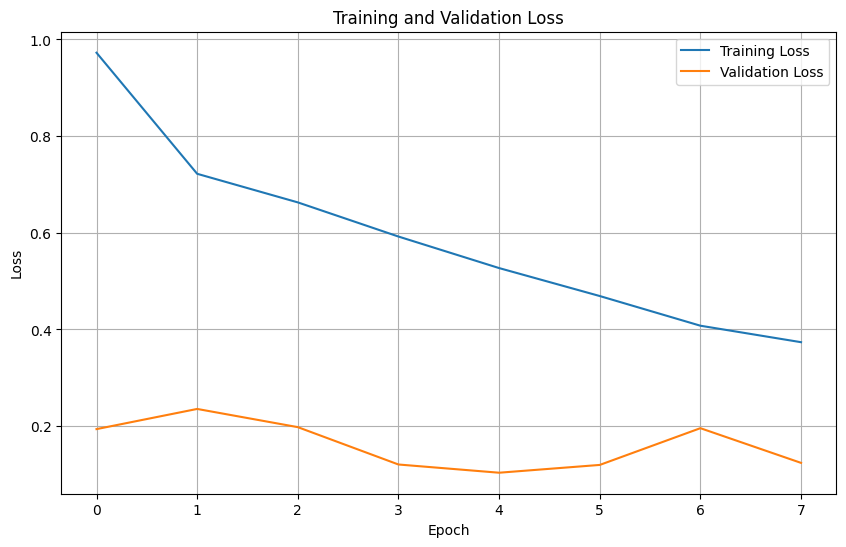

In [10]:
# Plot the training history of the best model (for demonstration, assuming the last trained model is the best)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.savefig(f"{DEFAULT_DATA_FOLDER}/charts/Training_loss_vs_loss.png")

In [11]:
import os
# Ensure the model directory exists
model_dir = os.path.join(DEFAULT_DATA_FOLDER, "models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model.save(f"{DEFAULT_DATA_FOLDER}/models/lstm.keras")

### Create confusion matrix

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/data/charts/global_confusion_matrix.png'

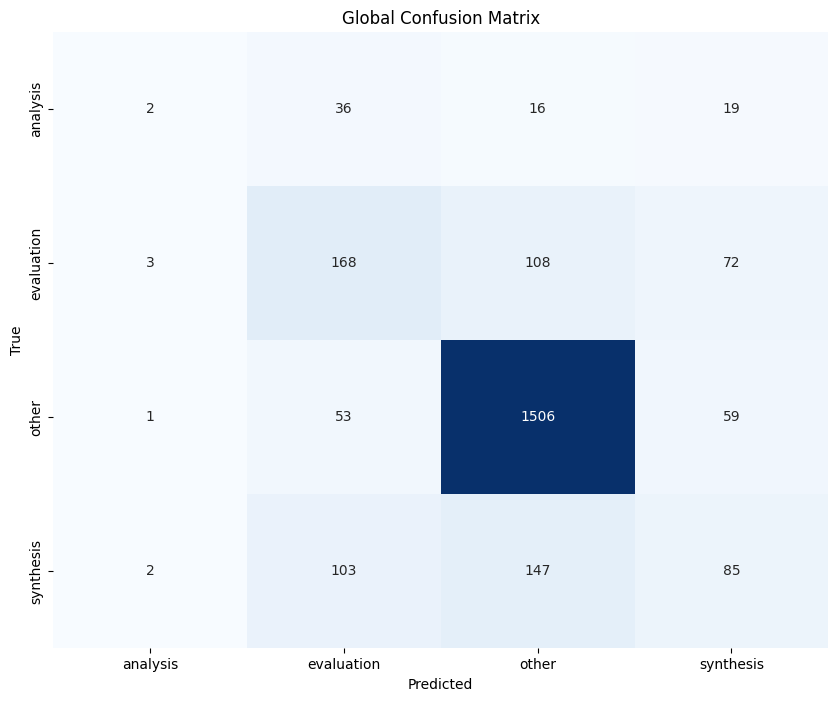

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize an empty list to store fold dataframes
folds_data = []

# Loop through each fold and read the corresponding Excel file
for fold in range(2, 12):
    fold_df = pd.read_excel(f"{DEFAULT_DATA_FOLDER}/validation_results/fold{fold}.xlsx")
    folds_data.append(fold_df)

# Concatenate all fold dataframes
combined_folds = pd.concat(folds_data)

# Extract true and predicted labels
y_true = combined_folds['true']
y_pred = combined_folds['predicted']

# Compute the global confusion matrix
global_conf_matrix = confusion_matrix(y_true, y_pred)
global_conf_matrix_df = pd.DataFrame(global_conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot the global confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(global_conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Global Confusion Matrix')
plt.savefig(f"{DEFAULT_DATA_FOLDER}/charts/global_confusion_matrix.png")
plt.close()

# Save the global confusion matrix as an Excel file
global_conf_matrix_df.to_excel(f"{DEFAULT_DATA_FOLDER}/validation_results/global_confusion_matrix.xlsx")

In [15]:
import pickle

# Path to save the tokenizer
TOKENIZER_PATH = os.path.join(DEFAULT_DATA_FOLDER, 'tokenizer.pickle')

# Save the tokenizer
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
classes_path = os.path.join(DEFAULT_DATA_FOLDER, 'classes.npy')
np.save(classes_path, label_encoder.classes_)